

---


# **Pipeline de Dados do Telegram**
Projeto Desenvolvido por Julia Luz, para o fechamento do curso Profissão Analista de Dados da EBAC.


---



# 1. Introdução
Um chatbot é um sistema automatizado que interage com usuários por meio de plataformas de mensagens, como Telegram, WhatsApp e websites. Seu objetivo é captar, processar e responder mensagens de forma autônoma e em tempo real. Neste projeto, foi implementado um chatbot no Telegram para captar mensagens de um grupo em que ele estava inserido.

As mensagens capturadas são consideradas dados transacionais, pois são geradas em tempo real e possuem alta volatilidade — no caso do Telegram, ficam armazenadas por apenas 24 horas. O projeto tem como objetivo converter esses dados em dados analíticos, por meio de seu armazenamento e processamento, permitindo análises mais aprofundadas. Para isso, foi utilizada a Amazon Web Services (AWS), responsável por armazenar e transformar os dados para sua posterior visualização.

**Arquitetura:**

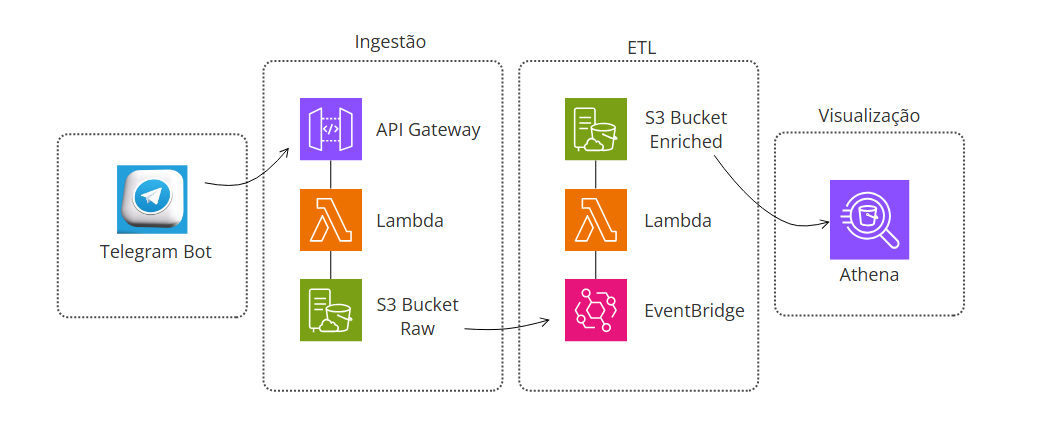

#. Criação do Bot
Para a extração dos dados foi criado o grupo Proj. Pipeline, com participação de 2 usuários e o bot que fará a captação das mensagens.

A criação do bot foi realizada através da ferramenta BotFather, nativa do Telegram.

- Bot:

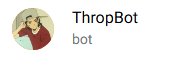

 O Bot fornece um Token que permite a busca das mensagens que foram enviadas nas últimas 24h via API, através do código:



```
base_url = f'https://api.telegram.org/bot{tolken}' # Tolken = Tolken do Bot fornecido em sua criação.
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2)) # Mensagem
```



A resposta obtida é do tipo json, com a seguinte estrutura:


```
{
      "update_id": x,
      "message": {
        "message_id": y,
        "from": {
            "id": z,
            "is_bot": false,
            "first_name": "Julia"
         },
         "chat": {
            "id": -...,
            "type": "supergroup"
        },
        "date": 1727033495,
        "text": "hello word"
      }
}
```



#3. Ingestão dos dados
Como o Telegram retem mensagens em seus servidores por um curto período, será utilizada a ingestão via streaming (em tempo real). Para que seja possível esse tipo de ingestão, vamos utilizar um webhook (gancho web), ou seja, vamos redirecionar as mensagens automaticamente para outra API web. Para tanto, o AWS API Gateway servirá de webhook, que enviará o conteúdo ao AWS Lambda, que por sua vez, irá armazenar o dado em seu formato original (JSON) em um bucket do AWS S3.

### 3.1 Definindo o webhook
Para definir o webhook, utilizou-se o código:


```
import requests

base_url = f'https://api.telegram.org/bot{tolken}' # Tolken = Tolken do Bot fornecido em sua criação.
aws_api_gateway_url = ... # URL do API rest criada no AWS API Gateway

webhook = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(webhook.text), indent=2)) # Verificando se a implementação teve sucesso```



###3.2 Bucket de dados crus:

Criou-se o seguinte bucket de dados crus no S3 Bucket:

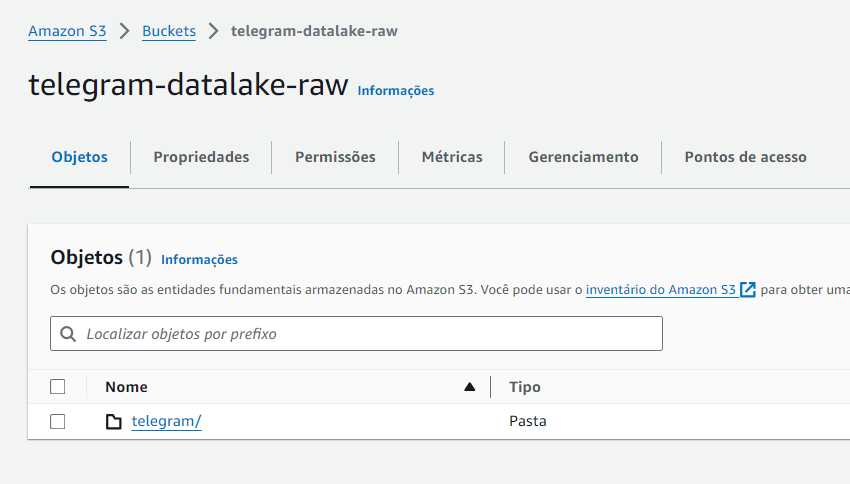

###3.3 Utilizando o AWS Lambda:

Para colocar a mensagem que estava na API dentro do bucket telegram-datalake-raw, utilizou-se a seguinte função, no lambda:



```
# Código implementado no AWS Lambda para persistir a mensagem captada na API para o bucket de armazenamento de dados crus no AWS S3:

import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:


  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET'] # Nome do bucket
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID']) # ID do chat

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")
```



**No lambda:**

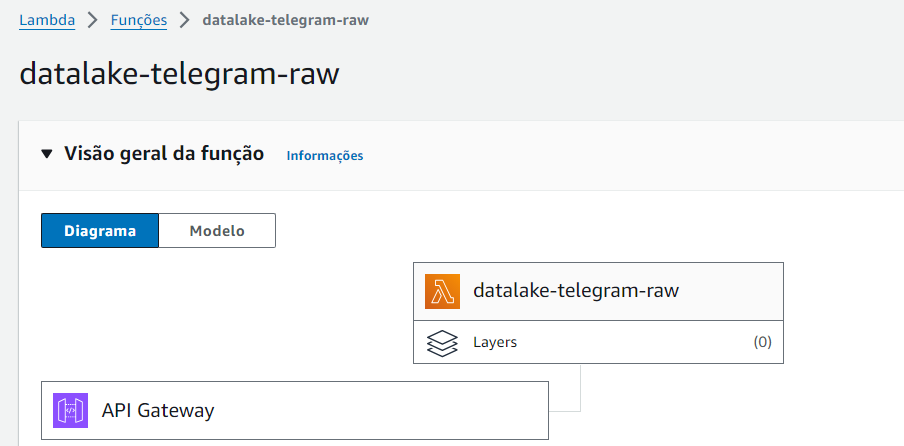

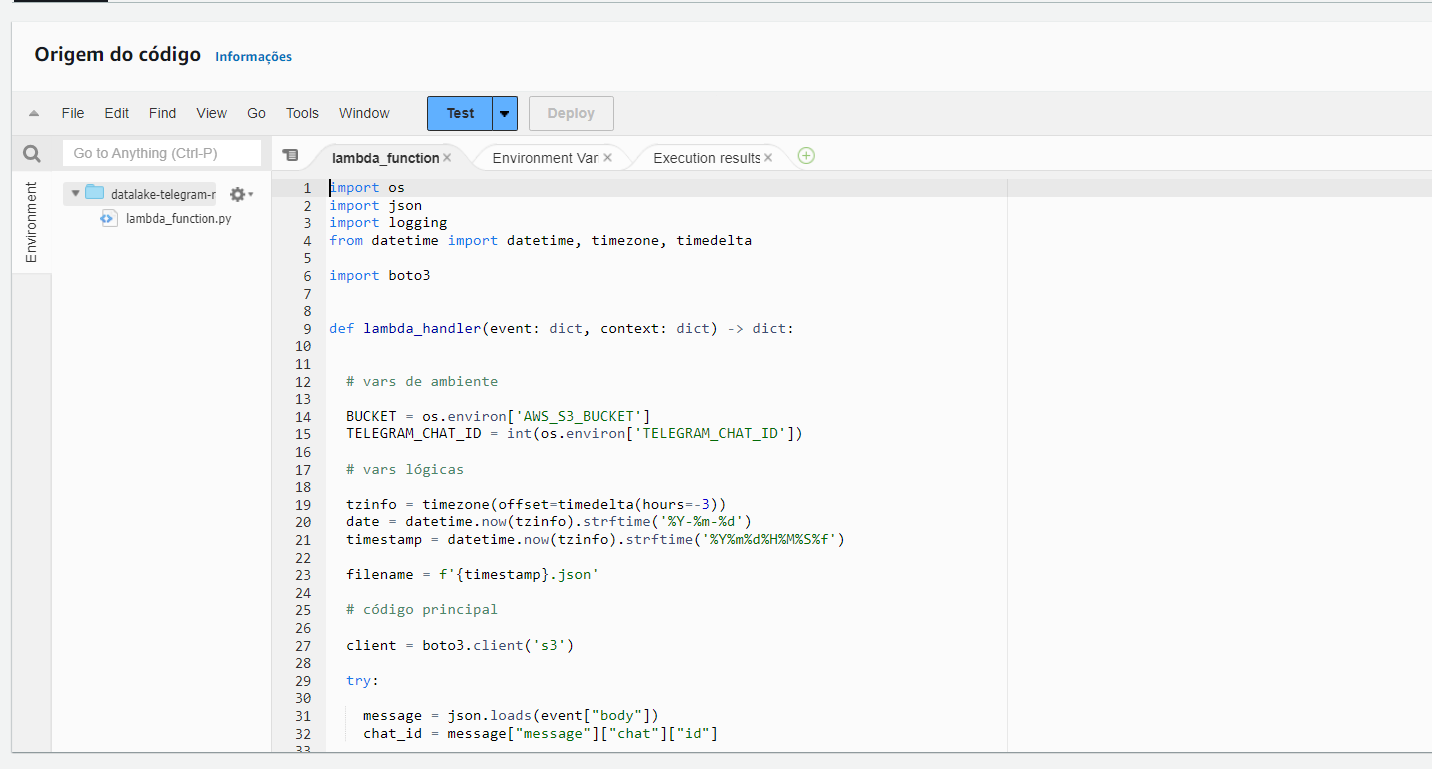

###3.4 Mensagens armazenadas no bucket após o processo:

Cada dia possui uma pasta:

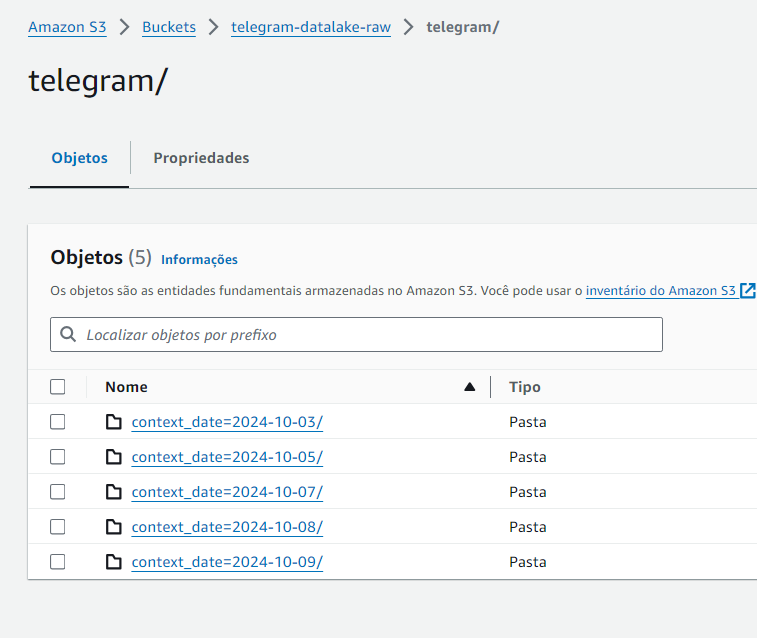

E, em cada pasta, está as mensagens do dia:

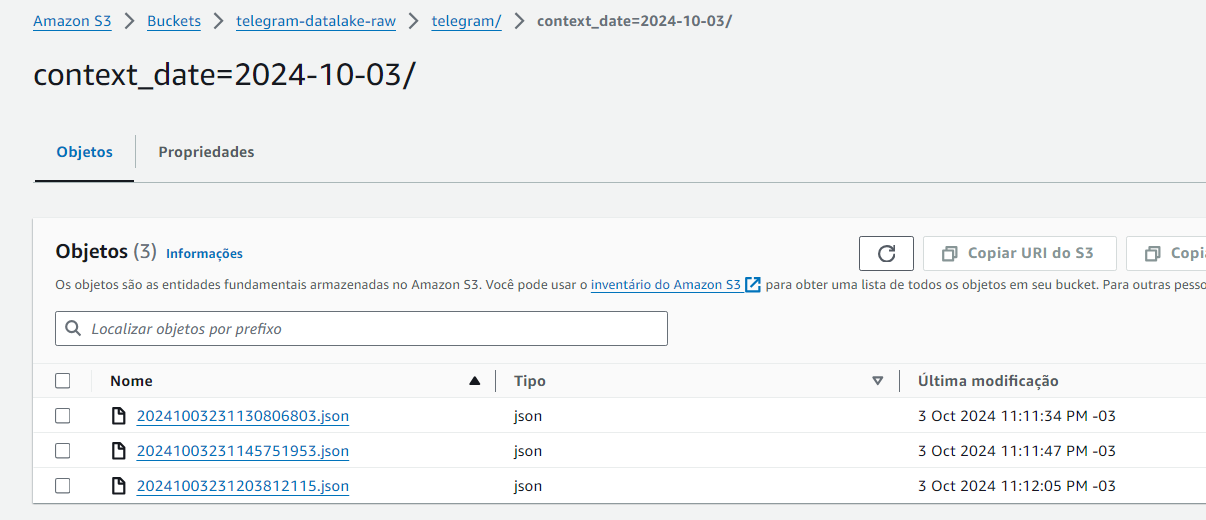

#4. Extração, Transformação e carregamento:
Em cada pasta — que representava um dia — havia várias mensagens, cada uma armazenada em um arquivo separado. Todas essas mensagens foram unificadas em um único arquivo, com formato colunar, comprimido e particionado por data de envio, sendo então armazenado na camada enriquecida. Para garantir que esse processo fosse executado diariamente, foi configurada uma regra no AWS EventBridge como gatilho diário da função responsável.

###4.1 Bucket enriquecido:
Criou-se o seguinte bucket de dados enriquecidos no S3 Bucket:

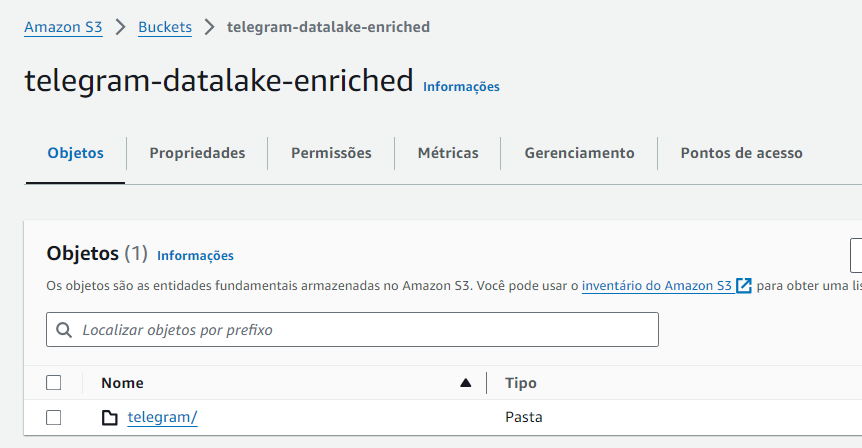

###4.2 Utilizando o AWS Lambda:
Para realizar as transformações supramencionadas utilizou-se a seguinte função, no lambda:


```
# Código da função lambda para transformação dos dados e seu armazenamento no novo bucket:

import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:


  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False
```



**No lambda:**

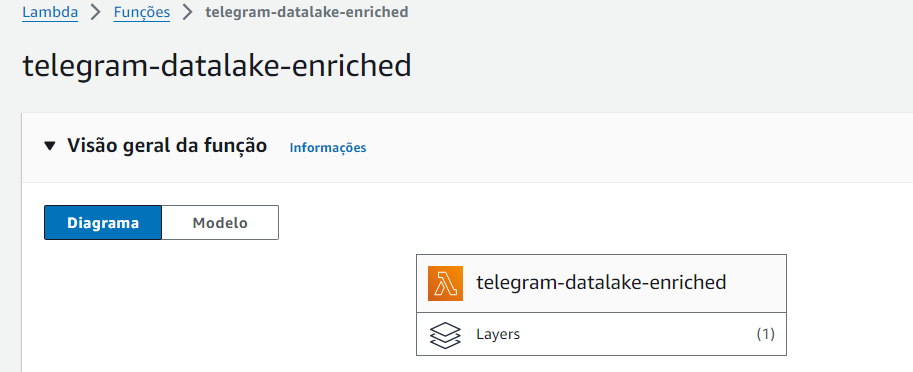

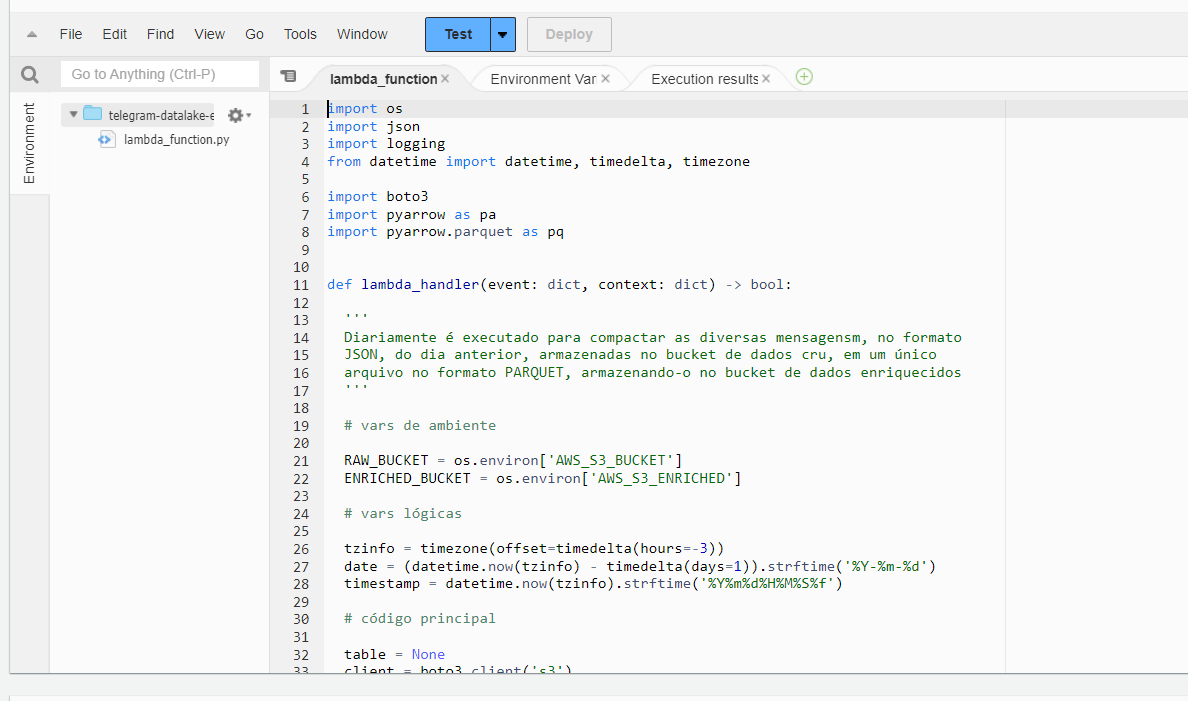

###4.3 Mensagens armazenadas no bucket após o processo:

As pastas ainda representam o dia:

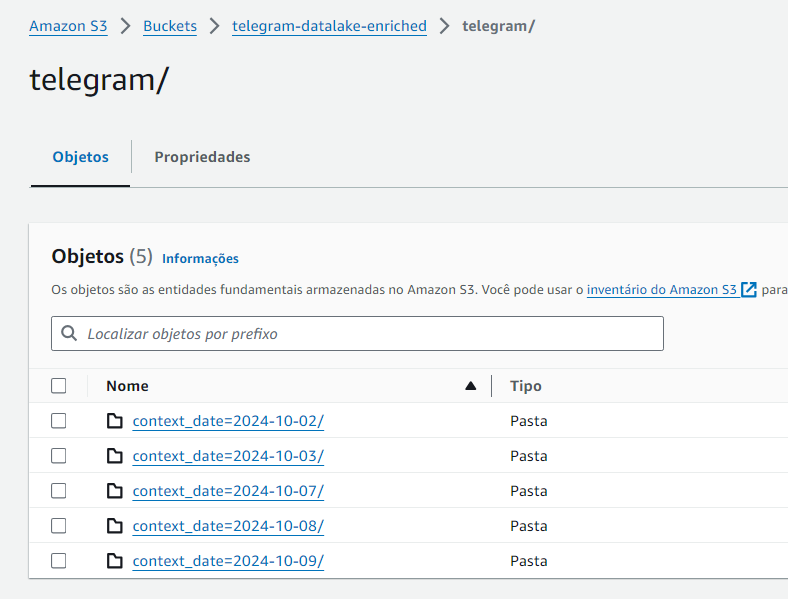

Mas agora as mensagens estão em um único arquivo:

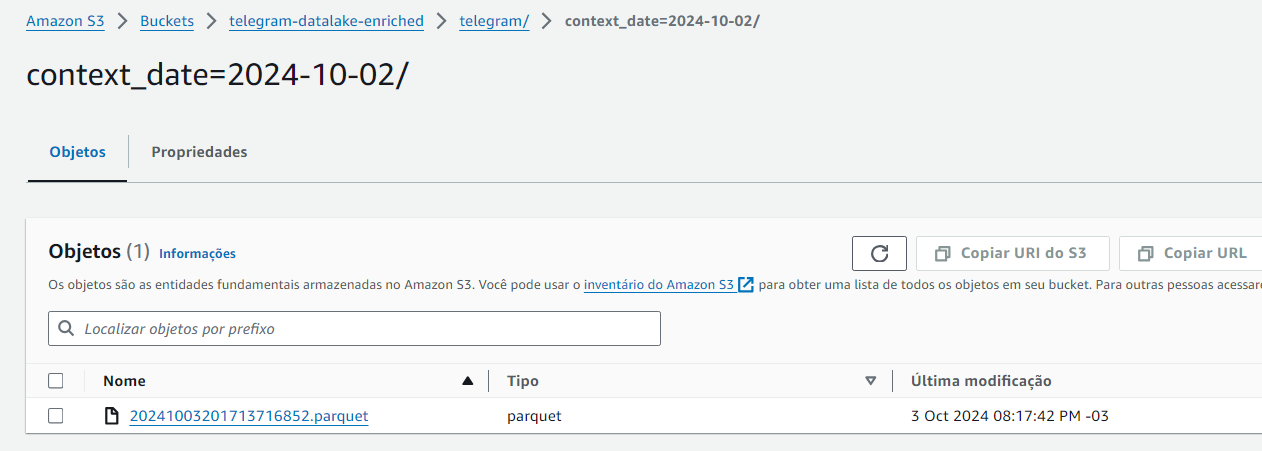

#5. Visualização

Para a visualização, "importou-se" os dados armazenados no bucket telegram -datalke-enriched para dentro do AWS Athena, onde realizou-se as consultas que ajudariam a endenter os dados.

Contexto: Todas as mensagens foram enviadas simulando uma conversa com um chatbot que pretende esclarecer dúvidas dentro de um aplicativo bancário.

- Criação da tabela:

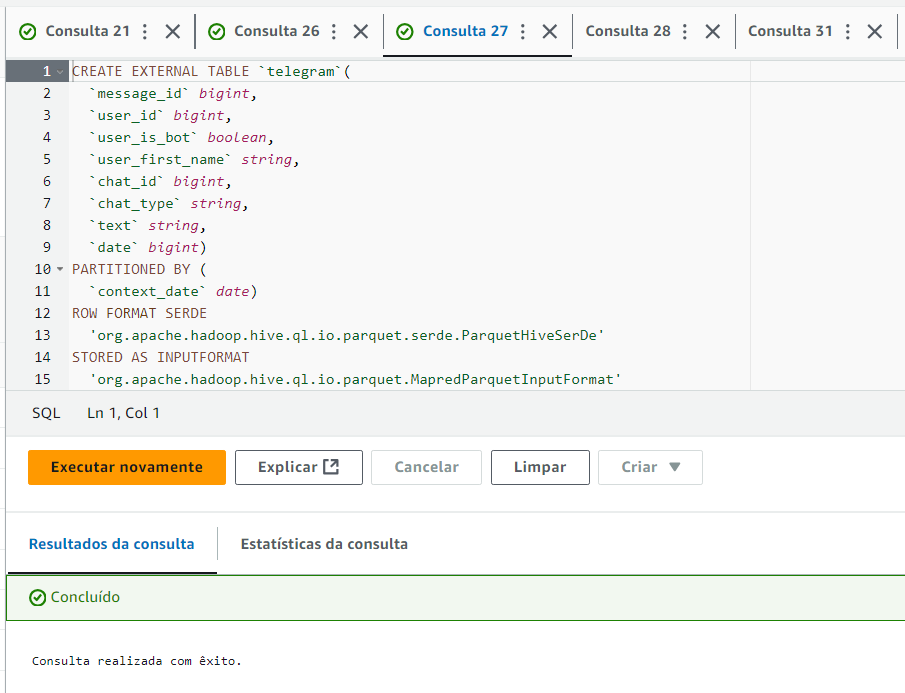

**Resultado**:

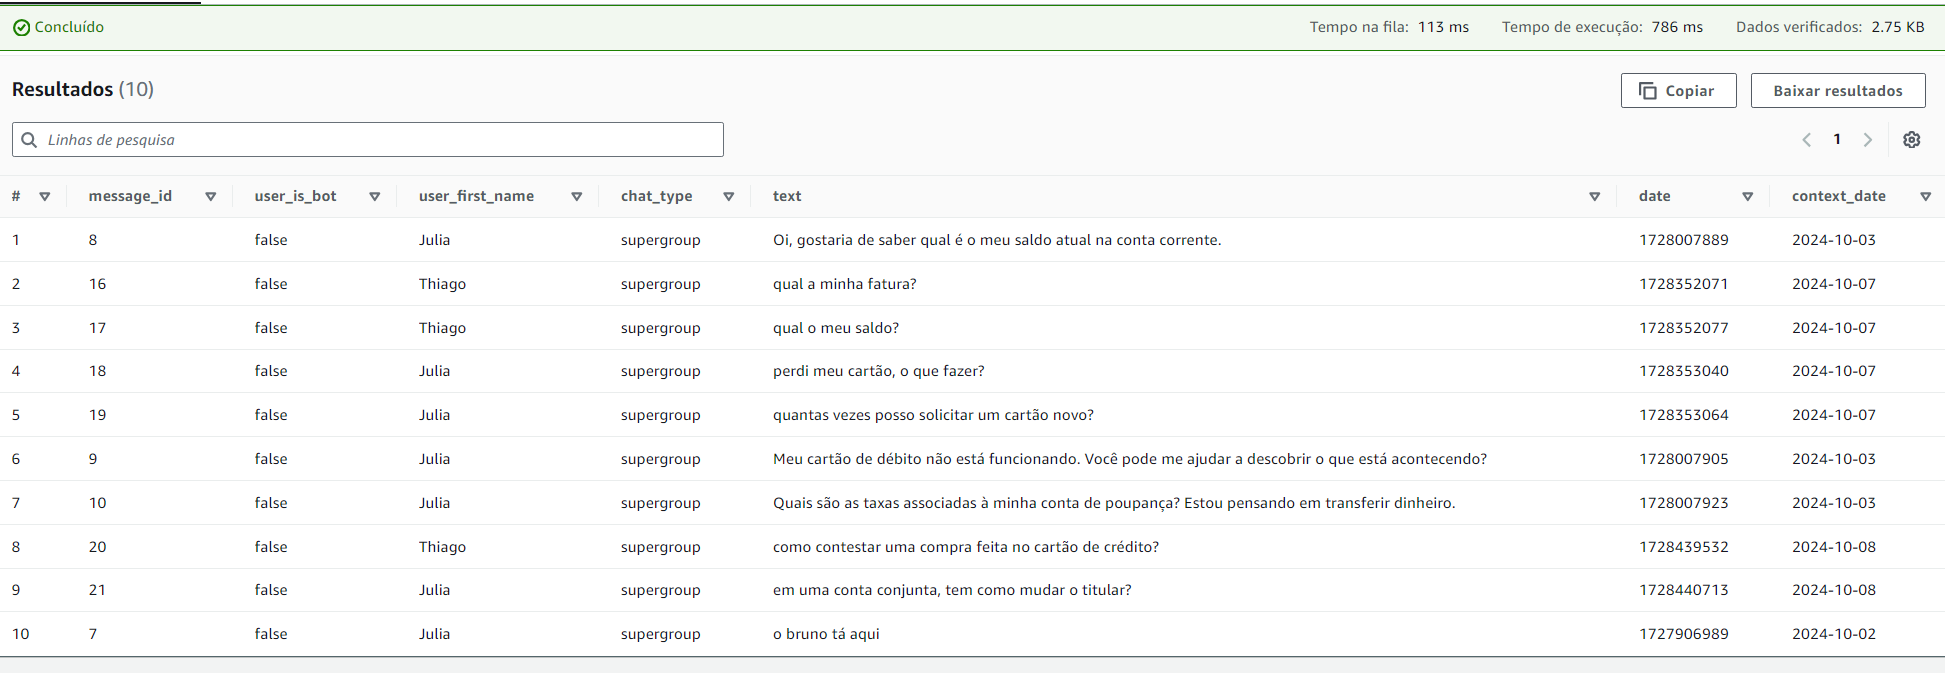

###5.1 Consultas realizadas, utilizando a linguagem SQL

In [ ]:
# 1. Número de mensagens enviadas a cada dia:

SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC;

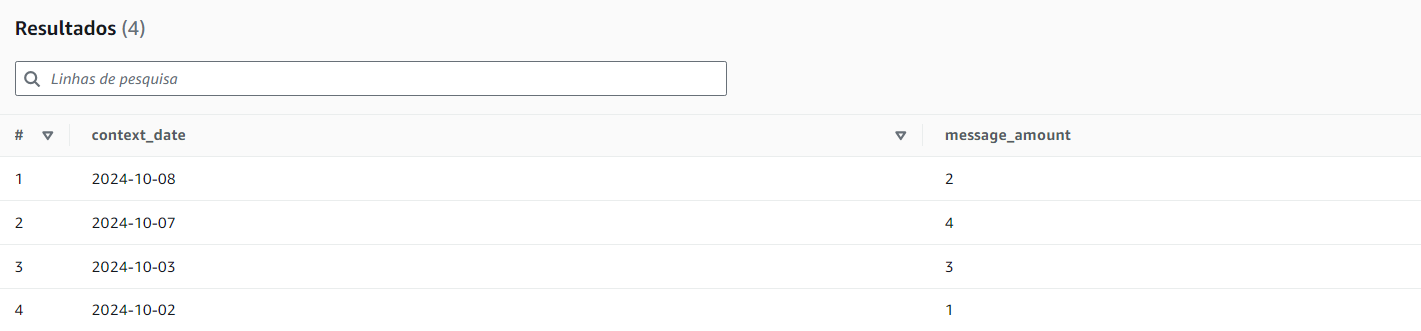

In [ ]:
# 2. Número de mensagens por usuário, por dia:

SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC

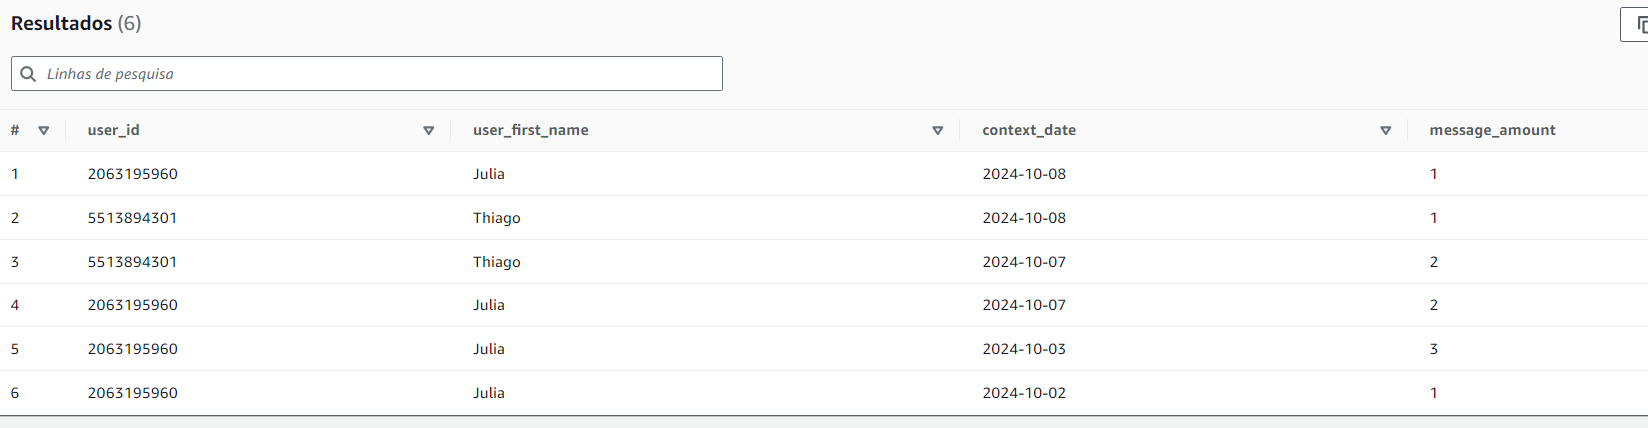

In [ ]:
# 3. Tamanho médio das mensagens enviadas por cada usuário em cada dia:


SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC;

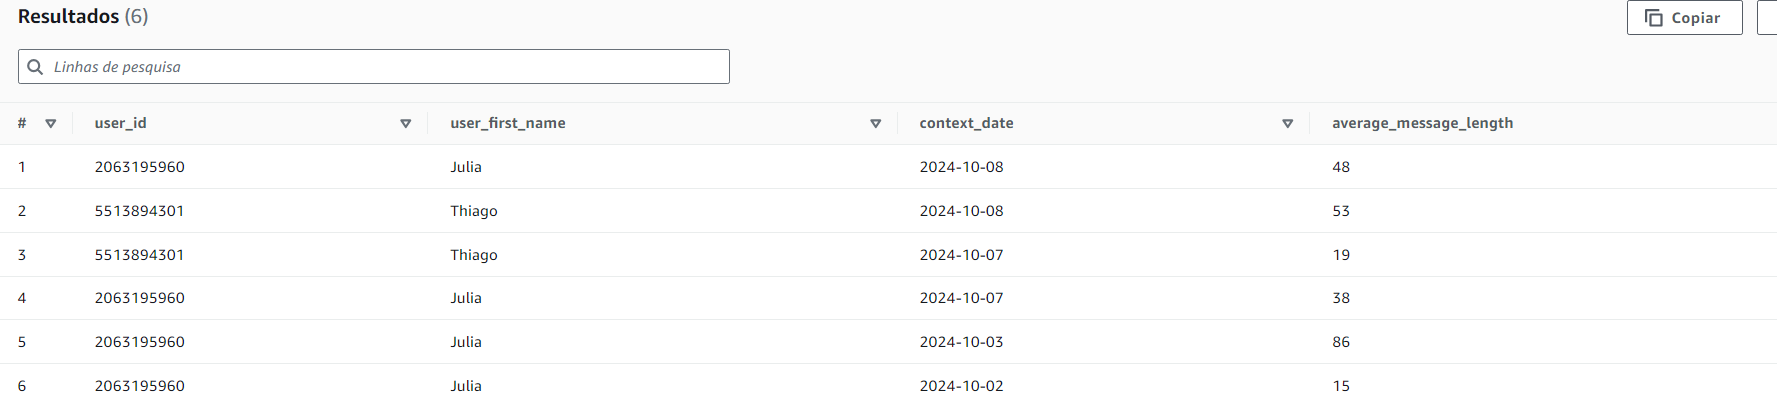

In [ ]:
# 4. Número de mensagens por hora, dia da semana e número da semana.

WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday

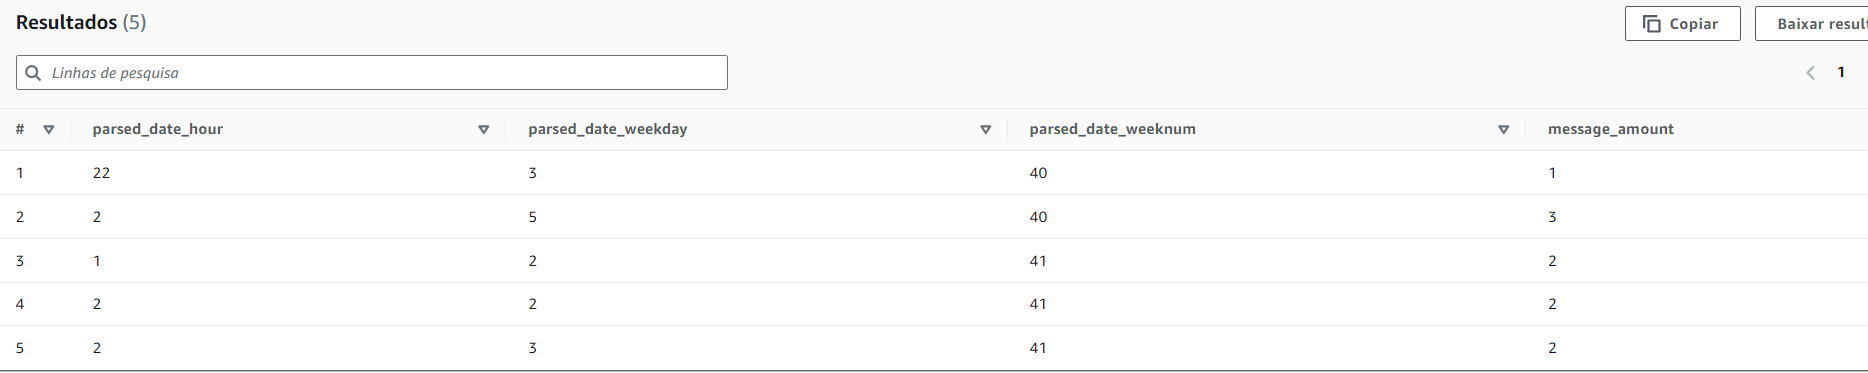

In [ ]:
# 5. Top 3 palavras mais frequentes

WITH word_split AS ( SELECT
        text, word FROM
        telegram,
        UNNEST(SPLIT(text, ' ')) AS t(word)
         WHERE LOWER(word) NOT IN ('meu', 'minha', 'de', 'a', 'o', 'qual', 'uma', 'está', 'em', 'como', 'que')
)
SELECT word, COUNT(*) AS word_count FROM word_split GROUP BY word ORDER BY word_count DESC LIMIT 3;

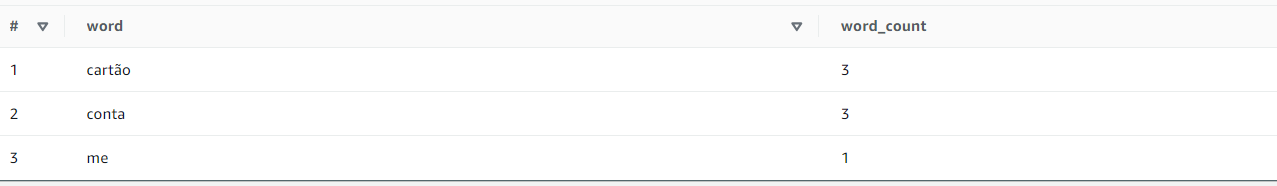

- Esclarecimentos:

Essas consultas foram realizadas buscando identificar:
1. A frequência de interação dos usuários com o bot, para constatar se eles estão tendo muitas dúvidas;
2. Se os usuários estão enviando muitas mensagens, pode significar que o bot não está conseguindo respondê-las de forma eficiente ou a plataforma em que o bot está alocado está gerando muitas dúvidas de uso;
3. Mensagens mais compridas tendem a ser mais complexas, podendo dificultar a intrepetação do bot, portanto essa consulta ajudará a saber quanto de investimento será necessario para aprimorá-lo nesse aspecto;
4. Essa consulta ajudará a perceber se, após determinado período, onde pode ter havido mudanças na plataforma, a interação com o bot aumentou ou não;
5. Palavras que aparecem com mais frequência tendem a ser onde as pessoas tem mais dúvidas sobre o serviço que está sendo utilizado.

- Insights
1.Os usuários foram ativos no período noturno. Isso pode ocorrer em decorrência de no período matutino e vespertino eles estarem trabalhando, tendo tempo para lidar com suas dúvidas bancárias apenas no período noturno. Isso implica que ter um funcionário disponível nesse período para auxiliá-los seria interessante.

2.Com a recorrência de uma palavra específica mais frequente, pode-se supor que o bot não esteja conseguindo responder as perguntas que as contém com eficiência, poranto seria interessante atualizar as respostas do bot para esse assunto. Neste caso com respostas sobre as dúvidas de cartão de crédito e débito.

#6. Conclusão

Com esse projeto, conseguiu-se pegar mensagens de um chat e transformá-los em dados analíticos, onde, após a contextualização, foi possível verificar possíveis conportamentos e ter insights sobre onde melhorar a plataforma bancária fictícia.